# A/B Test Demo

 Simulate a controlled A/B experiment for a recommendation change and analyze whether the treatment moves the conversion metric.




In [1]:

!pip install statsmodels -q


## 1) Libraries



In [2]:
# imports
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import matplotlib.pyplot as plt
from datetime import datetime


## 2) Simulation settings



In [3]:
# reproducibility and experiment parameters
SEED = 97
np.random.seed(SEED)

# true conversion probabilities used to simulate data
p_control = 0.12    # control group true conversion
p_variant = 0.16    # treatment group true conversion

# traffic allocated to each arm
visitors_control = 5000
visitors_variant = 4800

# test significance threshold
alpha = 0.05

print("Simulation settings:", f"seed={SEED}, p_control={p_control}, p_variant={p_variant}")


Simulation settings: seed=97, p_control=0.12, p_variant=0.16


## 3) Simulate user-level outcomes
(creates DataFrame `df_ab` with 'arm' and 'converted' columns)


In [4]:
# simulate Bernoulli outcomes using random uniform draw (different style)
control_outcomes = (np.random.rand(visitors_control) < p_control).astype(int)
variant_outcomes = (np.random.rand(visitors_variant) < p_variant).astype(int)

df_control = pd.DataFrame({"arm": "control", "converted": control_outcomes})
df_variant = pd.DataFrame({"arm": "variant", "converted": variant_outcomes})

# combine into a tidy dataframe
df_ab = pd.concat([df_control, df_variant], ignore_index=True)
df_ab.head()


,arm,converted
0,control,0
1,control,0
2,control,0
3,control,0
4,control,0


## 4) Aggregate statistics
- Counts, conversion rates, lifts, standard errors (approx).


In [5]:
# aggregate
n_ctrl = df_control.shape[0]
n_var = df_variant.shape[0]
x_ctrl = int(df_control["converted"].sum())
x_var = int(df_variant["converted"].sum())

rate_ctrl = x_ctrl / n_ctrl
rate_var = x_var / n_var

abs_lift = rate_var - rate_ctrl
rel_lift = (abs_lift / rate_ctrl) * 100 if rate_ctrl > 0 else float("nan")

# approximate (Wald) standard errors per arm for quick reference
se_ctrl = (rate_ctrl * (1 - rate_ctrl) / n_ctrl) ** 0.5
se_var = (rate_var * (1 - rate_var) / n_var) ** 0.5


## 5) Statistical test (two-sample proportions z-test)
- Using statsmodels' `proportions_ztest`.


In [6]:
# z-test (counts and sample sizes)
counts = np.array([x_var, x_ctrl])   # order: variant, control (common arrangement)
nobs = np.array([n_var, n_ctrl])

z_stat, p_val_two_sided = proportions_ztest(count=counts, nobs=nobs, alternative='two-sided')

# Wilson confidence intervals for each arm (more reliable than Wald for many cases)
ci_var_low, ci_var_high = proportion_confint(count=x_var, nobs=n_var, alpha=alpha, method='wilson')
ci_ctrl_low, ci_ctrl_high = proportion_confint(count=x_ctrl, nobs=n_ctrl, alpha=alpha, method='wilson')

# pack results
results = {
    "n_control": n_ctrl,
    "n_variant": n_var,
    "conv_control": x_ctrl,
    "conv_variant": x_var,
    "rate_control": rate_ctrl,
    "rate_variant": rate_var,
    "abs_lift": abs_lift,
    "rel_lift_pct": rel_lift,
    "se_control": se_ctrl,
    "se_variant": se_var,
    "z_stat": z_stat,
    "p_value": p_val_two_sided,
    "ci_control": (ci_ctrl_low, ci_ctrl_high),
    "ci_variant": (ci_var_low, ci_var_high),
}


## 6) Results (print)


In [8]:
# pretty print summary
print("A/B Test")
print("-" * 36)
print(f"Run at: {datetime.utcnow().isoformat()} UTC")
print()
print(f"Control:    n={results['n_control']:,}, conv={results['conv_control']:,}, rate={results['rate_control']:.4%}")
print(f"Variant:    n={results['n_variant']:,}, conv={results['conv_variant']:,}, rate={results['rate_variant']:.4%}")
print()
print(f"Absolute lift (variant - control): {results['abs_lift']:.4%}")
print(f"Relative lift vs control: {results['rel_lift_pct']:.2f}%")
print()
print(f"z-statistic: {results['z_stat']:.4f}")
print(f"two-sided p-value: {results['p_value']:.5f}")
print()
print("95% Wilson CIs:")
print(f"  Control CI: [{results['ci_control'][0]:.4%}, {results['ci_control'][1]:.4%}]")
print(f"  Variant CI: [{results['ci_variant'][0]:.4%}, {results['ci_variant'][1]:.4%}]")
print()

if results['p_value'] < alpha:
    print(f"Conclusion: Statistically significant difference at alpha={alpha} (reject H0).")
else:
    print(f"Conclusion: No statistically significant difference at alpha={alpha} (fail to reject H0).")


A/B Test
------------------------------------
Run at: 2025-10-14T15:00:04.481321 UTC

Control:    n=5,000, conv=582, rate=11.6400%
Variant:    n=4,800, conv=769, rate=16.0208%

Absolute lift (variant - control): 4.3808%
Relative lift vs control: 37.64%

z-statistic: 6.2885
two-sided p-value: 0.00000

95% Wilson CIs:
  Control CI: [10.7804%, 12.5585%]
  Variant CI: [15.0104%, 17.0856%]

Conclusion: Statistically significant difference at alpha=0.05 (reject H0).


/tmp/ipython-input-3927068725.py:4: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print(f"Run at: {datetime.utcnow().isoformat()} UTC")


## 7) Visualization (horizontal bar + CI)


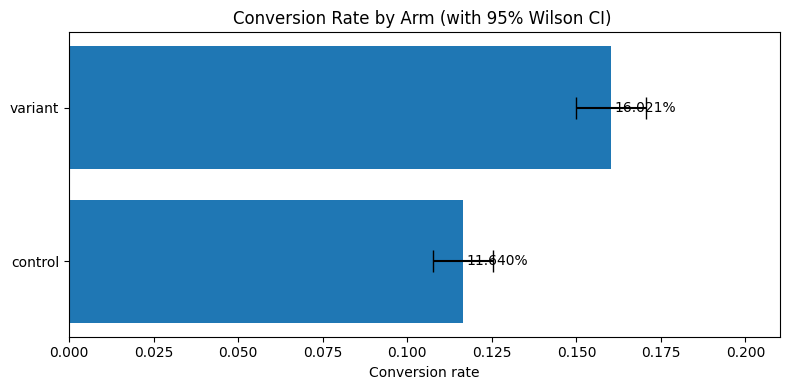

In [10]:
# compute half-widths for plotting from Wilson CIs
hw_ctrl = (results['ci_control'][1] - results['ci_control'][0]) / 2
hw_var  = (results['ci_variant'][1] - results['ci_variant'][0]) / 2

arms = ["control", "variant"]
rates = [results['rate_control'], results['rate_variant']]
errors = [hw_ctrl, hw_var]

fig, ax = plt.subplots(figsize=(8,4))
y_pos = np.arange(len(arms))
ax.barh(y_pos, rates, xerr=errors, align='center', capsize=8)
ax.set_yticks(y_pos)
ax.set_yticklabels(arms)
ax.set_xlabel("Conversion rate")
ax.set_title("Conversion Rate by Arm (with 95% Wilson CI) ")
for i, r in enumerate(rates):
    ax.text(r + 0.001, i, f"{r:.3%}", va='center')
plt.xlim(0, max(rates) + 0.05)
plt.tight_layout()
plt.show()
